In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from scipy import stats

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

import gc
from pathlib import Path

In [9]:
# set matplotlib ploting styles
sns.set()
sns.set_style('whitegrid')
sns.set_palette('muted')

In [10]:
def show_all_pandas(df, nrow=None, ncol=None):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [6]:
DATA_DIR = Path('../input/')

In [7]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [249]:
train_df['RESULT'].value_counts()

FUNDED        36023
NOT FUNDED     9619
Name: RESULT, dtype: int64

In [11]:
show_all_pandas(train_df.head())

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT    GDS  \
0  CAX_Train_1                1          900000              5429  61.98   
1  CAX_Train_2                2          386000              2179  35.22   
2  CAX_Train_3                3          531000              2152  30.97   
3  CAX_Train_4                4         1200000              5410  19.04   
4  CAX_Train_5                5          350000              3342  29.59   

     LTV    TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE MORTGAGE PURPOSE  \
0  65.00  71.63           360        1040000.0   4.0        Refinance   
1  74.29  40.65           360         390000.0   4.5        Refinance   
2  80.00  35.41           360         424800.0   3.5         Purchase   
3  75.00  34.14           360         960000.0   5.5         Purchase   
4  80.00  34.85           360         592000.0   5.0        Refinance   

  PAYMENT FREQUENCY    PROPERTY TYPE  TERM  FSA    AGE RANGE  GENDER  INCOME  \
0           Monthly  Single Detached    12  L4C     Under 25    Male  108000   
1           Monthly  Single Detached    12  L9T  70 and over    Male   78000   
2           Monthly  Single Detached     6  M1N        35-39  Female   87000   
3           Monthly  Single Detached    12  M2M        45-49    Male  300000   
4           Monthly  Single Detached    12  L7G        50-54    Male  147000   

   INCOME TYPE NAICS CODE  CREDIT SCORE  RESULT  
0            8      44-45           681  FUNDED  
1            2         56           710  FUNDED  
2            2         72           709  FUNDED  
3            8         54           761  FUNDED  
4            8         62           762  FUNDED

In [12]:
train_df.shape

(45642, 22)

In [13]:
# missing values info function
def missing_info(df):    
    x = df.isnull().sum()[(df.isnull().sum() > 0)]
    d = pd.DataFrame(x, columns=['missing values'])
    d['% of missing values'] = np.round((x/df.shape[0]) * 100, decimals=2)
    return d

In [14]:
# missing values in train set
missing_info(train_df)

Empty DataFrame
Columns: [missing values, % of missing values]
Index: []

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45642 entries, 0 to 45641
Data columns (total 22 columns):
Unique_ID            45642 non-null object
MORTGAGE NUMBER      45642 non-null int64
PROPERTY VALUE       45642 non-null int64
MORTGAGE PAYMENT     45642 non-null int64
GDS                  45642 non-null float64
LTV                  45642 non-null float64
TDS                  45642 non-null float64
AMORTIZATION         45642 non-null int64
MORTGAGE AMOUNT      45642 non-null float64
RATE                 45642 non-null float64
MORTGAGE PURPOSE     45642 non-null object
PAYMENT FREQUENCY    45642 non-null object
PROPERTY TYPE        45642 non-null object
TERM                 45642 non-null int64
FSA                  45642 non-null object
AGE RANGE            45642 non-null object
GENDER               45642 non-null object
INCOME               45642 non-null int64
INCOME TYPE          45642 non-null int64
NAICS CODE           45642 non-null object
CREDIT SCORE         45642 non-nu

In [23]:
train_df.describe().T

count           mean            std        min        25%  \
MORTGAGE NUMBER   45642.0   22821.500000   13175.854830      1.000   11411.25   
PROPERTY VALUE    45642.0  582611.038079  438208.208543  14000.000  340000.00   
MORTGAGE PAYMENT  45642.0    2392.148043    1688.208721    141.000    1406.00   
GDS               45642.0     213.803294   32637.664466    -37.040      19.84   
LTV               45642.0      70.632932      11.566444      6.667      65.00   
TDS               45642.0     412.566952   64258.594878    -10.700      32.84   
AMORTIZATION      45642.0     355.309583      18.011798     60.000     360.00   
MORTGAGE AMOUNT   45642.0  425570.446942  302046.876942  15000.000  245925.00   
RATE              45642.0       4.651149       0.642371      2.500       4.25   
TERM              45642.0      15.286578       7.443857      6.000      12.00   
INCOME            45642.0  125109.307217  114997.379964   1000.000   68000.00   
INCOME TYPE       45642.0       5.315017       3.267761     -1.000       2.00   
CREDIT SCORE      45642.0     662.662811     132.818234      0.000     623.00   

                        50%        75%         max  
MORTGAGE NUMBER    22821.50   34231.75     45642.0  
PROPERTY VALUE    477000.00  685000.00  18000000.0  
MORTGAGE PAYMENT    2033.00    2866.00     46479.0  
GDS                   29.21      35.87   6872300.0  
LTV                   75.00      80.00        95.0  
TDS                   38.30      42.17  13462562.5  
AMORTIZATION         360.00     360.00       480.0  
MORTGAGE AMOUNT   357500.00  512000.00   7500000.0  
RATE                   4.50       5.00        10.0  
TERM                  12.00      12.00        60.0  
INCOME             97000.00  145000.00   3860000.0  
INCOME TYPE            6.00       8.00        20.0  
CREDIT SCORE         677.00     736.00       899.0

In [125]:
train_df['PAYMENT FREQUENCY'].value_counts()

Monthly                  42785
Bi-Weekly                 1803
Bi-Weekly Accelerated     1047
Semi-Monthly                 4
Weekly                       2
Weekly Accelerated           1
Name: PAYMENT FREQUENCY, dtype: int64

In [149]:
def calculate_emi(principle, annual_rate, loan_tenure, pay_freq):
    if pay_freq == 'Monthly':
        pay_freq_year = 12
        total_pay_tenure = pay_freq_year * (loan_tenure / 12)
        unit_rate = (float(annual_rate)/100/pay_freq_year)
        emi = principle * unit_rate * (unit_rate + 1)**total_pay_tenure / ((unit_rate + 1)**total_pay_tenure - 1)
        first_interest_pay = principle * unit_rate
        first_principle_pay = emi - first_interest_pay
    
    # return emi, first_principle_pay, first_interest_pay
    return emi

In [155]:
temp = train_df[train_df['PAYMENT FREQUENCY'] == 'Monthly'].copy()
temp['x'] = temp.apply(lambda x: calculate_emi(x['MORTGAGE AMOUNT'], x['RATE'], x['AMORTIZATION'], x['PAYMENT FREQUENCY']), axis=1)
(temp['MORTGAGE PAYMENT'] - temp['x']).describe()

count    42785.000000
mean       269.530711
std        337.320216
min     -26149.326793
25%        172.059635
50%        259.621103
75%        361.495091
max      15682.573570
dtype: float64

In [138]:
emi(1000000, 10, 120, 'Monthly')

(13215.073688176193, 4881.740354842859, 8333.333333333334)

In [139]:
emi(322500.0, 4.25, 360, 'Monthly')

(1586.5061487313105, 444.31864873131053, 1142.1875)

In [15]:
show_all_pandas(test_df.head())

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT    GDS  \
0  CAX_Test_1            45643          430000              1861  34.51   
1  CAX_Test_2            45644          676000              1032  37.18   
2  CAX_Test_3            45645          418000               949  23.30   
3  CAX_Test_4            45646          693000              3059  42.45   
4  CAX_Test_5            45647          324000              1554  42.97   

     LTV    TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE MORTGAGE PURPOSE  \
0  75.00  35.60           360         322500.0  4.25        Refinance   
1  55.51  37.50           360         375000.0  5.00         Purchase   
2  79.90  32.88           360         334000.0  4.75        Refinance   
3  80.00  42.59           360         554400.0  4.25         Purchase   
4  75.00  43.48           360         243000.0  4.00         Purchase   

  PAYMENT FREQUENCY    PROPERTY TYPE  TERM  FSA AGE RANGE  GENDER  INCOME  \
0           Monthly        High Rise    24  M9B     45-49    Male   76000   
1         Bi-Weekly    Semi-Detached    12  M3N     55-59  Female   75000   
2         Bi-Weekly  Single Detached    60  K2H     30-34    Male   70000   
3           Monthly  Single Detached    24  L3R  Under 25  Female   90000   
4           Monthly  Single Detached    12  L2S     35-39    Male   48000   

   INCOME TYPE NAICS CODE  CREDIT SCORE  RESULT  
0            8         23           834     NaN  
1            2         56           804     NaN  
2            8         72           730     NaN  
3            2      44-45           786     NaN  
4            2         56           787     NaN

In [16]:
test_df.shape

(15214, 22)

In [17]:
missing_info(test_df)

missing values  % of missing values
RESULT           15214                100.0

In [110]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15214 entries, 0 to 15213
Data columns (total 25 columns):
Unique_ID              15214 non-null object
MORTGAGE NUMBER        15214 non-null int64
PROPERTY VALUE         15214 non-null int64
MORTGAGE PAYMENT       15214 non-null int64
GDS                    15214 non-null float64
LTV                    15214 non-null float64
TDS                    15214 non-null float64
AMORTIZATION           15214 non-null int64
MORTGAGE AMOUNT        15214 non-null float64
RATE                   15214 non-null float64
MORTGAGE PURPOSE       15214 non-null object
PAYMENT FREQUENCY      15214 non-null object
PROPERTY TYPE          15214 non-null object
TERM                   15214 non-null int64
FSA                    15214 non-null object
AGE RANGE              15214 non-null object
GENDER                 15214 non-null object
INCOME                 15214 non-null int64
INCOME TYPE            15214 non-null int64
NAICS CODE             15214 non-null 

In [21]:
test_df.describe().T

count           mean            std       min        25%  \
MORTGAGE NUMBER   15214.0   53249.500000    4392.047833  45643.00   49446.25   
PROPERTY VALUE    15214.0  579044.169844  417527.710573  36000.00  337000.00   
MORTGAGE PAYMENT  15214.0    2384.620350    1608.625935    208.00    1397.00   
GDS               15214.0    2306.920791  193385.316861    -48.78      19.97   
LTV               15214.0      70.748041      11.580747      6.90      65.00   
TDS               15214.0    2754.329645  209271.480183    -42.04      32.93   
AMORTIZATION      15214.0     355.208361      18.421023    120.00     360.00   
MORTGAGE AMOUNT   15214.0  423722.363278  289890.060107    333.88  244145.00   
RATE              15214.0       4.643010       0.633511      2.50       4.25   
TERM              15214.0      15.405022       7.531778      6.00      12.00   
INCOME            15214.0  124187.393190  111012.183595   1000.00   67000.00   
INCOME TYPE       15214.0       5.324438       3.303275     -1.00       2.00   
CREDIT SCORE      15214.0     663.116800     133.943360      0.00     624.00   
RESULT                0.0            NaN            NaN       NaN        NaN   

                        50%        75%           max  
MORTGAGE NUMBER    53249.50   57052.75  6.085600e+04  
PROPERTY VALUE    474000.00  680000.00  7.500000e+06  
MORTGAGE PAYMENT    2025.00    2850.00  2.503200e+04  
GDS                   29.30      36.10  2.138046e+07  
LTV                   75.00      80.00  9.332500e+01  
TDS                   38.36      42.22  2.274796e+07  
AMORTIZATION         360.00     360.00  4.800000e+02  
MORTGAGE AMOUNT   356250.00  511185.04  4.760000e+06  
RATE                   4.50       5.00  1.000000e+01  
TERM                  12.00      12.00  6.000000e+01  
INCOME             97000.00  144000.00  2.125000e+06  
INCOME TYPE            6.00       8.00  1.900000e+01  
CREDIT SCORE         678.00     736.00  8.990000e+02  
RESULT                  NaN        NaN           NaN

In [37]:
train_df['Unique_ID'].nunique()

45642

In [39]:
train_df['MORTGAGE NUMBER'].nunique()

45642

In [34]:
train_df['RESULT'].value_counts(normalize=True)

FUNDED        0.789251
NOT FUNDED    0.210749
Name: RESULT, dtype: float64

In [24]:
train_df['real_property_value'] = (train_df['MORTGAGE AMOUNT'] / train_df['LTV']) * 100
test_df['real_property_value'] = (test_df['MORTGAGE AMOUNT'] / test_df['LTV']) * 100

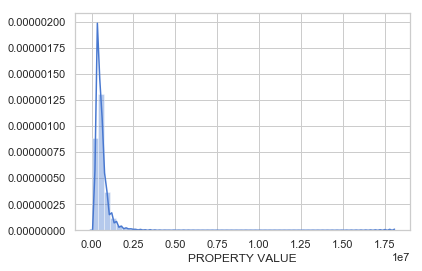

In [35]:
sns.distplot((train_df['PROPERTY VALUE']))

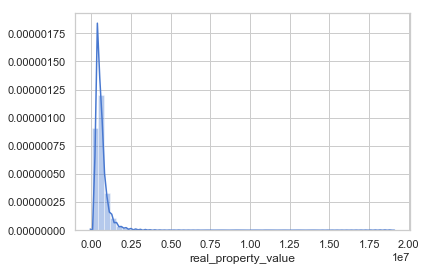

In [36]:
sns.distplot((train_df['real_property_value']))

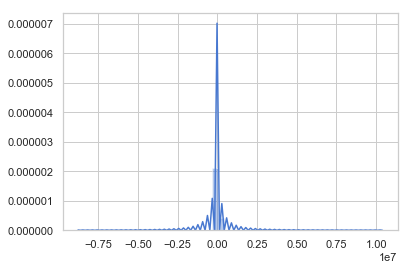

In [29]:
sns.distplot((train_df['real_property_value'] - train_df['PROPERTY VALUE']))

In [47]:
train_df['value_increase'] = ((train_df['PROPERTY VALUE'] - train_df['real_property_value']) > 0).astype(int)
train_df.loc[train_df['value_increase'] == 0, 'value_increase'] = -1
train_df.loc[train_df['real_property_value'] == train_df['PROPERTY VALUE'], 'value_increase'] = 0

test_df['value_increase'] = ((test_df['PROPERTY VALUE'] - test_df['real_property_value']) > 0).astype(int)
test_df.loc[test_df['value_increase'] == 0, 'value_increase'] = -1
test_df.loc[test_df['real_property_value'] == test_df['PROPERTY VALUE'], 'value_increase'] = 0

In [49]:
train_df['value_increase'].value_counts(normalize=True)

-1    0.389904
 0    0.338855
 1    0.271241
Name: value_increase, dtype: float64

In [50]:
test_df['value_increase'].value_counts(normalize=True)

-1    0.396148
 0    0.336795
 1    0.267057
Name: value_increase, dtype: float64

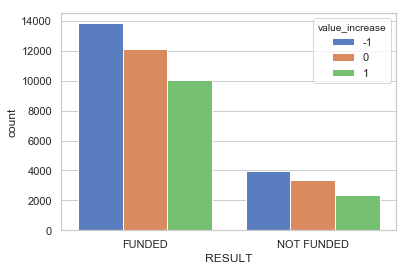

In [58]:
sns.countplot(train_df['RESULT'], hue=train_df['value_increase'])

In [54]:
train_df['perc_value_change'] = ((train_df['PROPERTY VALUE'] - train_df['real_property_value']) / train_df['real_property_value']) * 100
test_df['perc_value_change'] = ((test_df['PROPERTY VALUE'] - test_df['real_property_value']) / test_df['real_property_value']) * 100

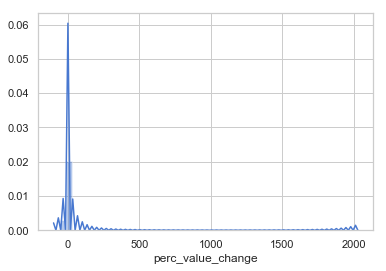

In [61]:
sns.distplot(train_df['perc_value_change'])

In [56]:
(train_df['perc_value_change'] < 0).sum()

17796

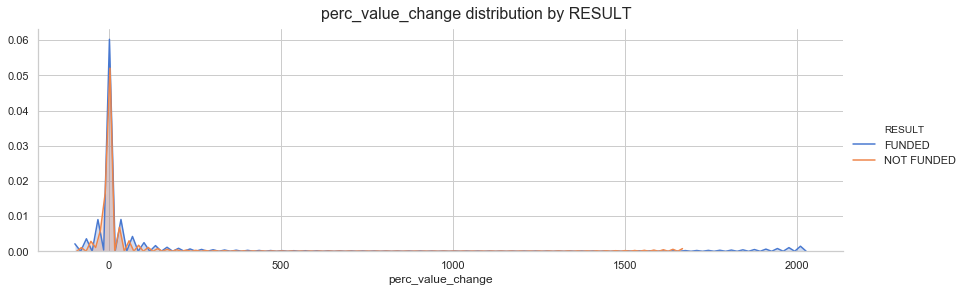

In [60]:
facet = sns.FacetGrid(train_df, hue = 'RESULT', size=4, aspect=3)
facet.fig.suptitle(('perc_value_change' + ' distribution' + ' by ' + 'RESULT'), fontsize=16, y=1.01)
facet.map(sns.kdeplot, 'perc_value_change', shade=True)
facet.add_legend()

In [124]:
train_df['PAYMENT FREQUENCY'].value_counts()

Monthly                  42785
Bi-Weekly                 1803
Bi-Weekly Accelerated     1047
Semi-Monthly                 4
Weekly                       2
Weekly Accelerated           1
Name: PAYMENT FREQUENCY, dtype: int64

In [55]:
show_all_pandas(train_df[((train_df['real_property_value'] - train_df['PROPERTY VALUE']) > 3e+6)])

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT  \
3923    CAX_Train_3924             3924          535000              2257   
8534    CAX_Train_8535             8535          627000               970   
12792  CAX_Train_12793            12793          805000             16253   
13702  CAX_Train_13703            13703          650000              3408   
14069  CAX_Train_14070            14070         1000000             17172   
15913  CAX_Train_15914            15914         2225000             10161   
17807  CAX_Train_17808            17808         2020000             20464   
18130  CAX_Train_18131            18131         2500000             27432   
18888  CAX_Train_18889            18889         2100000             16099   
24622  CAX_Train_24623            24623         2590000             21386   
24701  CAX_Train_24702            24702          435000              2029   
30504  CAX_Train_30505            30505          832000              3716   
35003  CAX_Train_35004            35004          543000             46479   
36258  CAX_Train_36259            36259          810000             16274   
37326  CAX_Train_37327            37327         2150000             26986   

          GDS     LTV     TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE  \
3923    34.36  73.333   34.36           360        3850000.0  4.75   
8534    22.50  11.907   35.23           300         501600.0  4.25   
12792   43.74  65.000   44.04           360        2892500.0  5.00   
13702   26.44  75.000   31.67           300        4587500.0  6.00   
14069   20.14  65.000   70.43           360        2625000.0  6.00   
15913  289.84  24.413  291.49           360        1300000.0  6.00   
17807   31.57  64.910   39.75           360        3700000.0  5.00   
18130   35.76  72.270   35.87           360        4680000.0  5.25   
18888   19.23  50.333   38.54           360        3020000.0  5.00   
24622   21.32  55.360   39.73           360        3100000.0  6.00   
24701   28.49  80.000   40.05           360        3480000.0  4.50   
30504   30.50  15.480   42.88           360         624300.0  4.25   
35003   40.69  64.020   42.16           360        7000000.0  6.00   
36258   82.82  65.000   84.16           360        2827500.0  5.75   
37326  100.19  53.750  105.91           360        4000000.0  6.00   

      MORTGAGE PURPOSE PAYMENT FREQUENCY    PROPERTY TYPE  TERM  FSA  \
3923         Refinance           Monthly  Single Detached    12  M1B   
8534          Purchase           Monthly  Single Detached    12  T8C   
12792        Refinance           Monthly  Single Detached    12  L4C   
13702        Refinance           Monthly    Semi-Detached    12  M4L   
14069        Refinance           Monthly  Single Detached    12  L4C   
15913         Purchase           Monthly  Single Detached    12  M6B   
17807        Refinance           Monthly  Single Detached    12  M2L   
18130        Refinance           Monthly  Single Detached    24  L4B   
18888        Refinance           Monthly  Single Detached    12  M4N   
24622        Refinance           Monthly  Single Detached    12  M5P   
24701         Purchase           Monthly  Single Detached    36  T6M   
30504         Purchase           Monthly        High Rise    12  M5R   
35003         Purchase           Monthly  Single Detached    24  M2H   
36258        Refinance           Monthly  Single Detached    12  L6P   
37326        Refinance           Monthly  Single Detached    12  M4W   

         AGE RANGE   GENDER   INCOME  INCOME TYPE NAICS CODE  CREDIT SCORE  \
3923         50-54     Male   192000            2         56           671   
8534         30-34     Male   200000            8      44-45           746   
12792        45-49     Male   450000            8         23           817   
13702        30-34     Male    69000            8         53           692   
14069        35-39   Female  1026000            8      44-45           579   
15913  70 and over  Unknown    43000  

In [158]:
train_df['mort_sub_prop'] = train_df['MORTGAGE AMOUNT'] - train_df['PROPERTY VALUE']
train_df['mort_div_prop'] = (train_df['MORTGAGE AMOUNT'] / train_df['PROPERTY VALUE']) * 100

test_df['mort_sub_prop'] = test_df['MORTGAGE AMOUNT'] - test_df['PROPERTY VALUE']
test_df['mort_div_prop'] = (test_df['MORTGAGE AMOUNT'] / test_df['PROPERTY VALUE']) * 100

In [159]:
show_all_pandas(train_df.head())

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT    GDS  \
0  CAX_Train_1                1          900000              5429  61.98   
1  CAX_Train_2                2          386000              2179  35.22   
2  CAX_Train_3                3          531000              2152  30.97   
3  CAX_Train_4                4         1200000              5410  19.04   
4  CAX_Train_5                5          350000              3342  29.59   

     LTV    TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE MORTGAGE PURPOSE  \
0  65.00  71.63           360        1040000.0   4.0        Refinance   
1  74.29  40.65           360         390000.0   4.5        Refinance   
2  80.00  35.41           360         424800.0   3.5         Purchase   
3  75.00  34.14           360         960000.0   5.5         Purchase   
4  80.00  34.85           360         592000.0   5.0        Refinance   

  PAYMENT FREQUENCY    PROPERTY TYPE  TERM  FSA    AGE RANGE  GENDER  INCOME  \
0           Monthly  Single Detached    12  L4C     Under 25    Male  108000   
1           Monthly  Single Detached    12  L9T  70 and over    Male   78000   
2           Monthly  Single Detached     6  M1N        35-39  Female   87000   
3           Monthly  Single Detached    12  M2M        45-49    Male  300000   
4           Monthly  Single Detached    12  L7G        50-54    Male  147000   

   INCOME TYPE NAICS CODE  CREDIT SCORE  RESULT  real_property_value  \
0            8      44-45           681  FUNDED         1.600000e+06   
1            2         56           710  FUNDED         5.249697e+05   
2            2         72           709  FUNDED         5.310000e+05   
3            8         54           761  FUNDED         1.280000e+06   
4            8         62           762  FUNDED         7.400000e+05   

   value_increase  perc_value_change  mort_sub_prop  mort_div_prop  
0              -1         -43.750000       140000.0     115.555556  
1              -1         -26.471949         4000.0     101.036269  
2               0           0.000000      -106200.0      80.000000  
3              -1          -6.250000      -240000.0      80.000000  
4              -1         -52.702703       242000.0     169.142857

In [163]:
train_df.loc[train_df['PAYMENT FREQUENCY'] == 'Semi-Monthly', 'PAYMENT FREQUENCY'] = 'Bi-Weekly'
test_df.loc[test_df['PAYMENT FREQUENCY'] == 'Semi-Monthly', 'PAYMENT FREQUENCY'] = 'Bi-Weekly'

In [166]:
train_df['PAYMENT FREQUENCY'].value_counts()

Monthly                  42785
Bi-Weekly                 1807
Bi-Weekly Accelerated     1047
Weekly                       2
Weekly Accelerated           1
Name: PAYMENT FREQUENCY, dtype: int64

In [177]:
def emi_to_income_ratio(emi, term, income):
    if term == 'Monthly':
        return (emi * 12 / income) * 100
    elif term == 'Bi-Weekly':
        return (emi * 24 / income) * 100
    elif term == 'Bi-Weekly Accelerated':
        return (emi * 26 / income) * 100
    elif term == 'Weekly':
        return (emi * 48 / income) * 100
    else:
        return (emi * 52 / income) * 100

In [180]:
train_df['emi_div_income_annual'] = train_df.apply(lambda x: emi_to_income_ratio(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['INCOME']), axis=1)
test_df['emi_div_income_annual'] = test_df.apply(lambda x: emi_to_income_ratio(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['INCOME']), axis=1)

In [181]:
show_all_pandas(train_df.head())

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT    GDS  \
0  CAX_Train_1                1          900000              5429  61.98   
1  CAX_Train_2                2          386000              2179  35.22   
2  CAX_Train_3                3          531000              2152  30.97   
3  CAX_Train_4                4         1200000              5410  19.04   
4  CAX_Train_5                5          350000              3342  29.59   

     LTV    TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE MORTGAGE PURPOSE  \
0  65.00  71.63           360        1040000.0   4.0        Refinance   
1  74.29  40.65           360         390000.0   4.5        Refinance   
2  80.00  35.41           360         424800.0   3.5         Purchase   
3  75.00  34.14           360         960000.0   5.5         Purchase   
4  80.00  34.85           360         592000.0   5.0        Refinance   

  PAYMENT FREQUENCY    PROPERTY TYPE  TERM  FSA    AGE RANGE  GENDER  INCOME  \
0           Monthly  Single Detached    12  L4C     Under 25    Male  108000   
1           Monthly  Single Detached    12  L9T  70 and over    Male   78000   
2           Monthly  Single Detached     6  M1N        35-39  Female   87000   
3           Monthly  Single Detached    12  M2M        45-49    Male  300000   
4           Monthly  Single Detached    12  L7G        50-54    Male  147000   

   INCOME TYPE NAICS CODE  CREDIT SCORE  RESULT  real_property_value  \
0            8      44-45           681  FUNDED         1.600000e+06   
1            2         56           710  FUNDED         5.249697e+05   
2            2         72           709  FUNDED         5.310000e+05   
3            8         54           761  FUNDED         1.280000e+06   
4            8         62           762  FUNDED         7.400000e+05   

   value_increase  perc_value_change  mort_sub_prop  mort_div_prop  \
0              -1         -43.750000       140000.0     115.555556   
1              -1         -26.471949         4000.0     101.036269   
2               0           0.000000      -106200.0      80.000000   
3              -1          -6.250000      -240000.0      80.000000   
4              -1         -52.702703       242000.0     169.142857   

   emi_div_income_annual  
0              60.322222  
1              33.523077  
2              29.682759  
3              21.640000  
4              27.281633

In [196]:
def total_payment_tenure(emi, pay_freq, amort):
    if pay_freq == 'Monthly':
        return (emi * 12) * (amort / 12)
    elif pay_freq == 'Bi-Weekly':
        return (emi * 24) * (amort / 12)
    elif pay_freq == 'Bi-Weekly Accelerated':
        return (emi * 26) * (amort / 12)
    elif pay_freq == 'Weekly':
        return (emi * 48) * (amort / 12)
    else:
        return (emi * 52) * (amort / 12)

In [197]:
train_df['total_payment_tenure'] = train_df.apply(lambda x: total_payment_tenure(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['AMORTIZATION']), axis=1)
test_df['total_payment_tenure'] = test_df.apply(lambda x: total_payment_tenure(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['AMORTIZATION']), axis=1)

In [198]:
show_all_pandas(train_df.head())

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT    GDS  \
0  CAX_Train_1                1          900000              5429  61.98   
1  CAX_Train_2                2          386000              2179  35.22   
2  CAX_Train_3                3          531000              2152  30.97   
3  CAX_Train_4                4         1200000              5410  19.04   
4  CAX_Train_5                5          350000              3342  29.59   

     LTV    TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE MORTGAGE PURPOSE  \
0  65.00  71.63           360        1040000.0   4.0        Refinance   
1  74.29  40.65           360         390000.0   4.5        Refinance   
2  80.00  35.41           360         424800.0   3.5         Purchase   
3  75.00  34.14           360         960000.0   5.5         Purchase   
4  80.00  34.85           360         592000.0   5.0        Refinance   

  PAYMENT FREQUENCY    PROPERTY TYPE  TERM  FSA    AGE RANGE  GENDER  INCOME  \
0           Monthly  Single Detached    12  L4C     Under 25    Male  108000   
1           Monthly  Single Detached    12  L9T  70 and over    Male   78000   
2           Monthly  Single Detached     6  M1N        35-39  Female   87000   
3           Monthly  Single Detached    12  M2M        45-49    Male  300000   
4           Monthly  Single Detached    12  L7G        50-54    Male  147000   

   INCOME TYPE NAICS CODE  CREDIT SCORE  RESULT  real_property_value  \
0            8      44-45           681  FUNDED         1.600000e+06   
1            2         56           710  FUNDED         5.249697e+05   
2            2         72           709  FUNDED         5.310000e+05   
3            8         54           761  FUNDED         1.280000e+06   
4            8         62           762  FUNDED         7.400000e+05   

   value_increase  perc_value_change  mort_sub_prop  mort_div_prop  \
0              -1         -43.750000       140000.0     115.555556   
1              -1         -26.471949         4000.0     101.036269   
2               0           0.000000      -106200.0      80.000000   
3              -1          -6.250000      -240000.0      80.000000   
4              -1         -52.702703       242000.0     169.142857   

   emi_div_income_annual  total_payment_tenure  
0              60.322222             1954440.0  
1              33.523077              784440.0  
2              29.682759              774720.0  
3              21.640000             1947600.0  
4              27.281633             1203120.0

In [201]:
def total_payment_term(emi, pay_freq, term):
    if pay_freq == 'Monthly':
        return (emi * 12) * (term / 12)
    elif pay_freq == 'Bi-Weekly':
        return (emi * 24) * (term / 12)
    elif pay_freq == 'Bi-Weekly Accelerated':
        return (emi * 26) * (term / 12)
    elif pay_freq == 'Weekly':
        return (emi * 48) * (term / 12)
    else:
        return (emi * 52) * (term / 12)

In [202]:
train_df['total_payment_term'] = train_df.apply(lambda x: total_payment_term(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['TERM']), axis=1)
test_df['total_payment_term'] = test_df.apply(lambda x: total_payment_term(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['TERM']), axis=1)

In [203]:
show_all_pandas(train_df.head())

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT    GDS  \
0  CAX_Train_1                1          900000              5429  61.98   
1  CAX_Train_2                2          386000              2179  35.22   
2  CAX_Train_3                3          531000              2152  30.97   
3  CAX_Train_4                4         1200000              5410  19.04   
4  CAX_Train_5                5          350000              3342  29.59   

     LTV    TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE MORTGAGE PURPOSE  \
0  65.00  71.63           360        1040000.0   4.0        Refinance   
1  74.29  40.65           360         390000.0   4.5        Refinance   
2  80.00  35.41           360         424800.0   3.5         Purchase   
3  75.00  34.14           360         960000.0   5.5         Purchase   
4  80.00  34.85           360         592000.0   5.0        Refinance   

  PAYMENT FREQUENCY    PROPERTY TYPE  TERM  FSA    AGE RANGE  GENDER  INCOME  \
0           Monthly  Single Detached    12  L4C     Under 25    Male  108000   
1           Monthly  Single Detached    12  L9T  70 and over    Male   78000   
2           Monthly  Single Detached     6  M1N        35-39  Female   87000   
3           Monthly  Single Detached    12  M2M        45-49    Male  300000   
4           Monthly  Single Detached    12  L7G        50-54    Male  147000   

   INCOME TYPE NAICS CODE  CREDIT SCORE  RESULT  real_property_value  \
0            8      44-45           681  FUNDED         1.600000e+06   
1            2         56           710  FUNDED         5.249697e+05   
2            2         72           709  FUNDED         5.310000e+05   
3            8         54           761  FUNDED         1.280000e+06   
4            8         62           762  FUNDED         7.400000e+05   

   value_increase  perc_value_change  mort_sub_prop  mort_div_prop  \
0              -1         -43.750000       140000.0     115.555556   
1              -1         -26.471949         4000.0     101.036269   
2               0           0.000000      -106200.0      80.000000   
3              -1          -6.250000      -240000.0      80.000000   
4              -1         -52.702703       242000.0     169.142857   

   emi_div_income_annual  total_payment_tenure  total_payment_term  
0              60.322222             1954440.0             65148.0  
1              33.523077              784440.0             26148.0  
2              29.682759              774720.0             12912.0  
3              21.640000             1947600.0             64920.0  
4              27.281633             1203120.0             40104.0

In [ ]:
train_df['train_test'] = 'train'
test_df['train_test'] = 'test'

In [223]:
train_df['fsa_province'] = train_df['FSA'].str[0]
train_df['fsa_urban_rural'] = train_df['FSA'].str[0:2]

test_df['fsa_province'] = test_df['FSA'].str[0]
test_df['fsa_urban_rural'] = test_df['FSA'].str[0:2]

In [224]:
train_df.head()

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT    GDS  \
0  CAX_Train_1                1          900000              5429  61.98   
1  CAX_Train_2                2          386000              2179  35.22   
2  CAX_Train_3                3          531000              2152  30.97   
3  CAX_Train_4                4         1200000              5410  19.04   
4  CAX_Train_5                5          350000              3342  29.59   

     LTV    TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE       ...        \
0  65.00  71.63           360        1040000.0   4.0       ...         
1  74.29  40.65           360         390000.0   4.5       ...         
2  80.00  35.41           360         424800.0   3.5       ...         
3  75.00  34.14           360         960000.0   5.5       ...         
4  80.00  34.85           360         592000.0   5.0       ...         

  value_increase perc_value_change mort_sub_prop  mort_div_prop  \
0             -1        -43.750000      140000.0     115.555556   
1             -1        -26.471949        4000.0     101.036269   
2              0          0.000000     -106200.0      80.000000   
3             -1         -6.250000     -240000.0      80.000000   
4             -1        -52.702703      242000.0     169.142857   

  emi_div_income_annual total_payment_tenure total_payment_term  fsa_province  \
0             60.322222            1954440.0            65148.0             L   
1             33.523077             784440.0            26148.0             L   
2             29.682759             774720.0            12912.0             M   
3             21.640000            1947600.0            64920.0             M   
4             27.281633            1203120.0            40104.0             L   

   train_test fsa_urban_rural  
0       train              L4  
1       train              L9  
2       train              M1  
3       train              M2  
4       train              L7  

[5 rows x 33 columns]

In [225]:
all_df = train_df.append(test_df)

In [237]:
for col in ['fsa_province', 'fsa_urban_rural', 'FSA']:
    gb = all_df.groupby([col])['CREDIT SCORE'].agg(['mean', 'std', 'min', 'max']).reset_index()
    gb.columns = [col, col + '_credit_score_mean', col + '_credit_score_std', col + '_credit_score_min', col + '_credit_score_max']
    all_df = all_df.merge(gb, on=col, how='left')

In [238]:
show_all_pandas(all_df.head())

Unique_ID  MORTGAGE NUMBER  PROPERTY VALUE  MORTGAGE PAYMENT    GDS  \
0  CAX_Train_1                1          900000              5429  61.98   
1  CAX_Train_2                2          386000              2179  35.22   
2  CAX_Train_3                3          531000              2152  30.97   
3  CAX_Train_4                4         1200000              5410  19.04   
4  CAX_Train_5                5          350000              3342  29.59   

     LTV    TDS  AMORTIZATION  MORTGAGE AMOUNT  RATE MORTGAGE PURPOSE  \
0  65.00  71.63           360        1040000.0   4.0        Refinance   
1  74.29  40.65           360         390000.0   4.5        Refinance   
2  80.00  35.41           360         424800.0   3.5         Purchase   
3  75.00  34.14           360         960000.0   5.5         Purchase   
4  80.00  34.85           360         592000.0   5.0        Refinance   

  PAYMENT FREQUENCY    PROPERTY TYPE  TERM  FSA    AGE RANGE  GENDER  INCOME  \
0           Monthly  Single Detached    12  L4C     Under 25    Male  108000   
1           Monthly  Single Detached    12  L9T  70 and over    Male   78000   
2           Monthly  Single Detached     6  M1N        35-39  Female   87000   
3           Monthly  Single Detached    12  M2M        45-49    Male  300000   
4           Monthly  Single Detached    12  L7G        50-54    Male  147000   

   INCOME TYPE NAICS CODE  CREDIT SCORE  RESULT  real_property_value  \
0            8      44-45           681  FUNDED         1.600000e+06   
1            2         56           710  FUNDED         5.249697e+05   
2            2         72           709  FUNDED         5.310000e+05   
3            8         54           761  FUNDED         1.280000e+06   
4            8         62           762  FUNDED         7.400000e+05   

   value_increase  perc_value_change  mort_sub_prop  mort_div_prop  \
0              -1         -43.750000       140000.0     115.555556   
1              -1         -26.471949         4000.0     101.036269   
2               0           0.000000      -106200.0      80.000000   
3              -1          -6.250000      -240000.0      80.000000   
4              -1         -52.702703       242000.0     169.142857   

   emi_div_income_annual  total_payment_tenure  total_payment_term  \
0              60.322222             1954440.0             65148.0   
1              33.523077              784440.0             26148.0   
2              29.682759              774720.0             12912.0   
3              21.640000             1947600.0             64920.0   
4              27.281633             1203120.0             40104.0   

  fsa_province train_test fsa_urban_rural  fsa_province_credit_score_mean  \
0            L      train              L4                      659.786751   
1            L      train              L9                      659.786751   
2            M      train              M1                      681.103002   
3            M      train              M2                      681.103002   
4            L      train              L7                      659.786751   

   fsa_province_credit_score_std  fsa_province_credit_score_min  \
0                     130.338404                              0   
1                     130.338404                              0   
2                     127.205455                              0   
3                     127.205455                              0   
4                     130.338404                              0   

   fsa_province_credit_score_max  fsa_urban_rural_credit_score_mean  \
0                            899                         671.560162   
1                            899                         656.457584   
2                            897                         667.983537   
3                            897                         695.688763   
4                            899                         657.581995   

   fsa_urban_rural_credit_score_std  fsa_urban_rural_credit_

In [242]:
for col in ['FSA']:
    gb = all_df.groupby([col])['PROPERTY VALUE'].agg(['median', 'std', 'min', 'max']).reset_index()
    gb.columns = [col, col + '_property_value_mean', col + '_property_value_std', col + '_property_value_min', col + '_property_value_max']
    all_df = all_df.merge(gb, on=col, how='left')

In [243]:
for col in ['FSA']:
    gb = all_df.groupby([col])['LTV'].agg(['median', 'std', 'min', 'max']).reset_index()
    gb.columns = [col, col + '_ltv_mean', col + '_ltv_std', col + '_ltv_min', col + '_ltv_max']
    all_df = all_df.merge(gb, on=col, how='left')

In [244]:
for col in ['fsa_province']:
    gb = all_df.groupby([col])['RATE'].agg(['mean', 'std', 'min', 'max']).reset_index()
    gb.columns = [col, col + '_rate_mean', col + '_rate_std', col + '_rate_min', col + '_rate_max']
    all_df = all_df.merge(gb, on=col, how='left')

In [245]:
for col in ['FSA']:
    gb = all_df.groupby([col])['INCOME'].agg(['median', 'std', 'min', 'max']).reset_index()
    gb.columns = [col, col + '_income_median', col + '_income_std', col + '_income_min', col + '_income_max']
    all_df = all_df.merge(gb, on=col, how='left')

In [246]:
for col in ['PROPERTY TYPE']:
    gb = all_df.groupby([col])['PROPERTY VALUE'].agg(['median', 'std', 'min', 'max']).reset_index()
    gb.columns = [col, col + '_property_value_median', col + '_property_value_std', col + '_property_value_min', col + '_property_value_max']
    all_df = all_df.merge(gb, on=col, how='left')

In [248]:
all_df.shape

(60856, 65)

In [ ]:
#EMI to income ratio

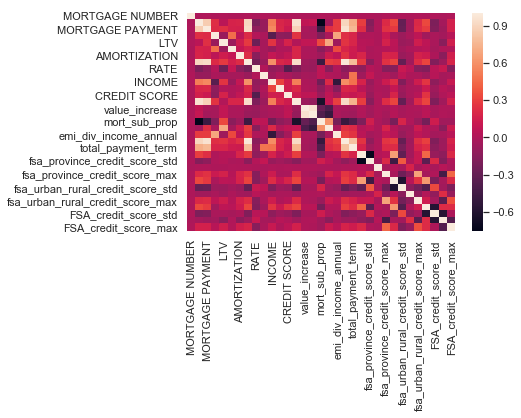

In [241]:
sns.heatmap(all_df.corr('spearman'))

https://www.investopedia.com/financial-edge/0411/5-things-you-need-to-be-pre-approved-for-a-mortgage.aspx

https://www.google.com/search?ei=UXDhXKmTAcmLvQTI8LO4Ag&q=mortgage+approval+prediction&oq=mortgage+approval+prediction&gs_l=psy-ab.3...20660.21407..24034...0.0..0.139.269.0j2......0....1..gws-wiz.......0i71.iKnieL2MtOo


https://www.google.co.in/search?source=hp&ei=AHHhXMqADIvgvATDnoKwCA&q=mortgage+approval+case+study&oq=mortgage+approval+case+study&gs_l=psy-ab.12..0i22i30.1330.10015..10155...0.0..0.157.2765.0j21......0....1..gws-wiz.....0..35i39j0i131j0j0i67j33i160.rJyo6mNeya4


http://faculty.haas.berkeley.edu/levine/papers/A%20Case%20Study%20of%20the%20Mortgage%20Application%20Process.pdf


https://www.google.com/search?q=segmentation+of+customers+for+mortgage+approval&oq=segmentation+of+customers+for++mortgage+approval&aqs=chrome..69i57.30557j0j7&sourceid=chrome&ie=UTF-8


https://www.google.com/search?q=mortgage+approval+in+canada&oq=mortgage+approval+in+cana&aqs=chrome.1.69i57j0l5.15535j0j7&sourceid=chrome&ie=UTF-8

https://www.bankbazaar.com/home-loan-emi-calculator.html?WT.mc_id=Branding_FB|_Quora_&utm_source=FB&utm_medium=DailyPost&utm_campaign=Branding


https://www.google.com/search?q=who+in+bank+decides+to+approv+a+loan&oq=who+in+bank+decides+to+approv+a+loan&aqs=chrome..69i57j69i64.11150j0j7&sourceid=chrome&ie=UTF-8



https://www.ratehub.ca/mortgage-payment-options


https://mozo.com.au/interest-rates/guides/calculate-interest-on-loan


http://www.differencebetween.net/business/finance-business-2/difference-between-bi-weekly-and-accelerated-bi-weekly/
